In [1]:
import stability_functions as sf
import numpy as np
from numpy.random import normal, seed, uniform
import os
import time
import sys
import rebound
import mr_forecast as mr
import numpy.random as rd
import corner
import copy
import scipy
import pandas as pd
from scipy import optimize
import random
import dill
import sys
sys.path.append("../spock")
from spock import StabilityClassifier
import dask.dataframe as dd
from celmech import Andoyer
from multiprocessing import Pool
# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
plt.style.use('paper.mplstyle')
cmaprb = mcol.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])
# %matplotlib inline

# Generating systems and scores

In [136]:
sim_names = "K431/K431_uni_dens"
use_log_e = False
n = 10000
n_workers = 4  # ?

In [137]:
def init_process():
    global model
    model = StabilityClassifier()
    
def pred(nsim):
    sim = rebound.SimulationArchive(sim_names + "_sa_%d.bin"%nsim)[0]
    sim.move_to_com()
    sim.integrator="whfast"
    sim.dt = 0.07*sim.particles[1].P
#     prob=model.predict(sim)
    prob=model.predict(sim, copy=False)
    return prob

def get_k(row):
    sim = rebound.SimulationArchive(sim_names + "_sa_%d.bin"%(row[0]))[0]
#     print(sim)
    p2 = sim.particles[2]
    row['h'] = p2.e*np.sin(p2.pomega)
    row['k'] = p2.e*np.cos(p2.pomega)
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=5, k=1, i1=1, i2=2, average=False)
    row['Z12'] = avars.Z
    row['Zcom12'] = avars.Zcom
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=4, k=1, i1=2, i2=3, average=False)
    row['Z23'] = avars.Z
    row['Zcom23'] = avars.Zcom
    row['e1'] = sim.particles[1].e
    row['e2'] = sim.particles[2].e
    row['e3'] = sim.particles[3].e
    row['m1'] = sim.particles[1].m
    row['m2'] = sim.particles[2].m
    row['m3'] = sim.particles[3].m
    return row

pool = Pool(processes=n_workers, initializer=init_process)

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. Th

In [138]:
%%time
log_min_e = np.ones(3) * np.log(1e-3)

# getting basic r-m scaling laws from https://www.saraseager.com/research/exoplanet-interior-composition/
h_exp = (np.log(10) - np.log(1)) / (np.log(5.96) - np.log(3.05))
fe_exp = (np.log(10) - np.log(1)) / (np.log(1.4) - np.log(0.7))

for i in range(n):
    name = sim_names + "_sa_%d.bin"%i
    Ps = np.array([sf.a_normal(6.80252171, 7.931e-05, 7.931e-05), sf.a_normal(8.70337044, 9.645e-05, 9.645e-05), sf.a_normal(11.9216214, 0.0001182, 0.0001182)])
    As = Ps ** (2./3)
    es = np.array([0,0,0])
    bad_es = True
    e0_max = sf.max_e_inner(As[0], As[1])
    e1_max = np.minimum(sf.max_e_inner(As[1], As[2], es[2]), sf.max_e_outer(As[1], As[0]))  # ~0.15
    e2_max = sf.max_e_outer(As[2], As[1])
    while bad_es:
        es = np.exp(rd.rand(3) * (np.log([e0_max, e1_max, e2_max]) - log_min_e) + log_min_e)
        if use_log_e:
            es = np.exp(rd.rand(3) * (np.log([e0_max, e1_max, e2_max]) - log_min_e) + log_min_e)
        else:
            es =rd.rand(3) * np.array([e0_max, e1_max, e2_max])
        bad_es = not sf.check_es(As[0], es[0], As[1], es[1], As[2], es[2])
    rs = np.array([sf.a_normal(1.088, 0.146, 0.146), sf.a_normal(1.072, 0.171, 0.171), sf.a_normal(1.307, 0.160, 0.160)])
    lower = np.exp((np.log(rs) - np.log(3.05)) * h_exp)
    upper = np.exp((np.log(rs) - np.log(0.7)) * fe_exp)
    ms = lower + rd.rand(3) * (upper - lower)
    sim = sf.build_chosen_K431(ms, es, Ps)
    sf.replace_snapshot(sim, name)

CPU times: user 6.66 s, sys: 1.46 s, total: 8.12 s
Wall time: 29.1 s


In [139]:
%%time
nsim_list = np.arange(0,n)
res = pool.map(pred, nsim_list)

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. Th

KeyboardInterrupt: 

  File "/storage/home/cjg66/miniconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/storage/home/cjg66/miniconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/storage/home/cjg66/miniconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [140]:
%%time
df1 = pd.DataFrame(nsim_list, columns=['sim'])
df1['k'] = 0.
df1['h'] = 0.
df1['Z12'] = 0.
df1['Zcom12'] = 0.
df1['Z23'] = 0.
df1['Zcom23'] = 0.
df1['e1'] = 0.
df1['e2'] = 0.
df1['e3'] = 0.
df1['m1'] = 0.
df1['m2'] = 0.
df1['m3'] = 0.
df1['probstability'] = res

dasklabels = dd.from_pandas(df1, npartitions=n_workers)
df = dasklabels.apply(get_k, axis=1, meta=df1).compute(scheduler='processes')

df.to_csv("K431_uni_dens.csv")

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


ValueError: Length of values does not match length of index

# Corner plots

In [2]:
df = pd.read_csv("K431_uni_dens.csv")
df["m1"] /= sf.earth_mass_2_solar_mass
df["m2"] /= sf.earth_mass_2_solar_mass
df["m3"] /= sf.earth_mass_2_solar_mass
df["m1+m2"] = df["m1"] + df["m2"]
df["m2+m3"] = df["m2"] + df["m3"]
df["total m"] = df["m1"] + df["m2"] + df["m3"]
# df

In [3]:
def quantile_1D(data, weights, quantile):
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    Sn =  np.array(np.cumsum(sorted_weights))
    Pn = (Sn-0.5*sorted_weights)/Sn[-1]
    return np.interp(quantile, Pn, sorted_data)

In [11]:
def create_hist(label, show_quantiles=True):
    plt.figure(figsize=(8,4.5))
    n_bins=50
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6)
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6, weights=df["probstability"])
#     plt.hist(df[label], bins=n_bins, alpha=0.6)
#     plt.hist(df[label], bins=n_bins, alpha=0.6, weights=df["probstability"])
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True)
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True, weights=df["probstability"])
    plt.title(label, size=30)
    if show_quantiles:
        quant1 = np.quantile(df[label], 0.16)
        quant2 = np.quantile(df[label], 0.84)
        plt.axvline(x=quant1, color="C0")
        plt.axvline(x=quant2, color="C0")
        quant3 = quantile_1D(df[label], df["probstability"], 0.16)
        quant4 = quantile_1D(df[label], df["probstability"], 0.84)
        plt.axvline(x=quant3, color="C1")
        plt.axvline(x=quant4, color="C1")
        sigma1 = (quant2 - quant1) / 2
        sigma2 = (quant4 - quant3) / 2
        print("\"sigma\" before: %f"%(sigma1))
        print("\"sigma\" after: %f"%(sigma2))
        print("factor of %f smaller"%(sigma1/sigma2))

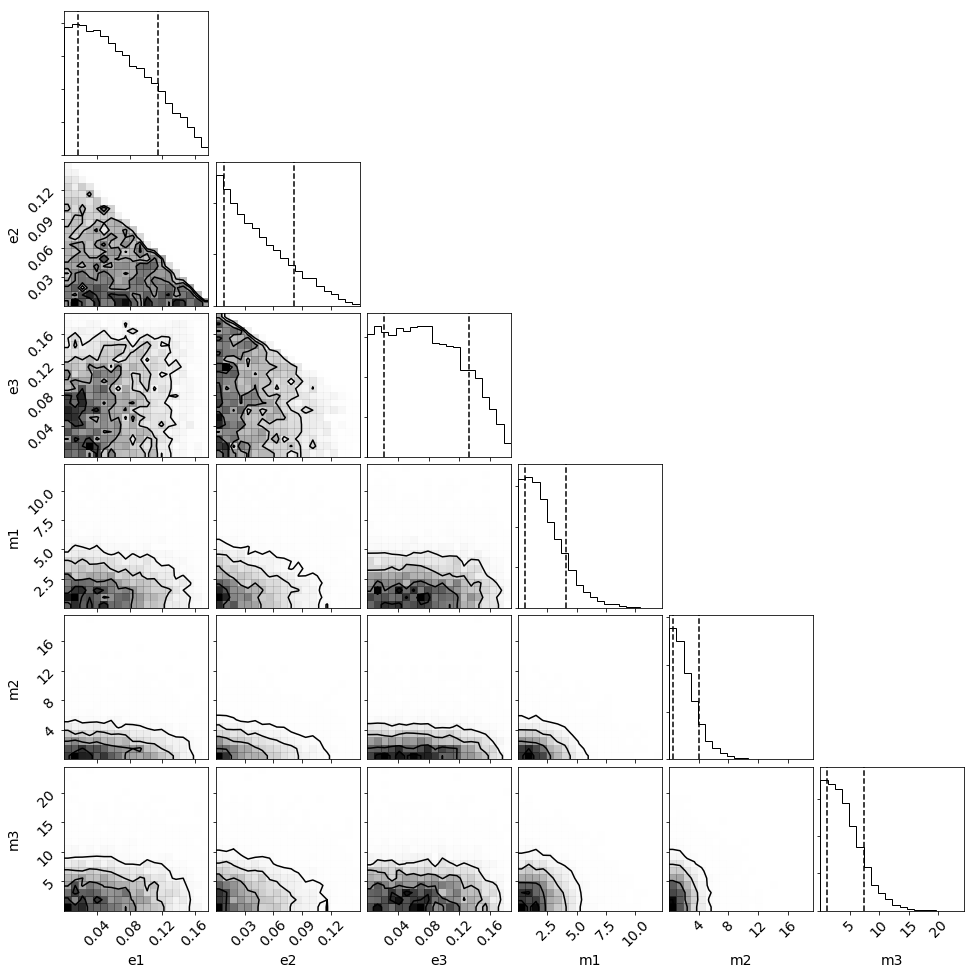

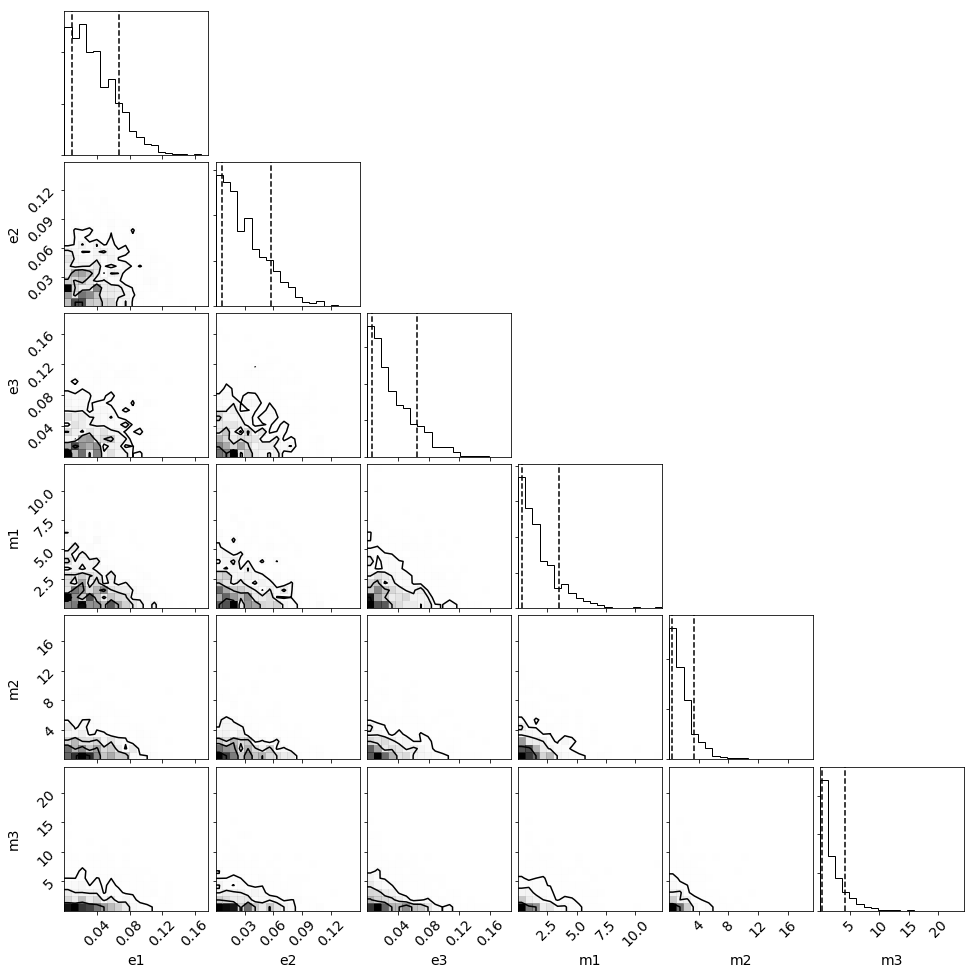

In [5]:
labels = ["e1","e2", "e3", "m1", "m2", "m3"]
fig = corner.corner(df[labels], labels=labels, quantiles=[0.15,0.85], plot_datapoints=False)
plt.show()
fig = corner.corner(df[labels], labels=labels, quantiles=[0.15,0.85], plot_datapoints=False, weights=df["probstability"])
plt.show()

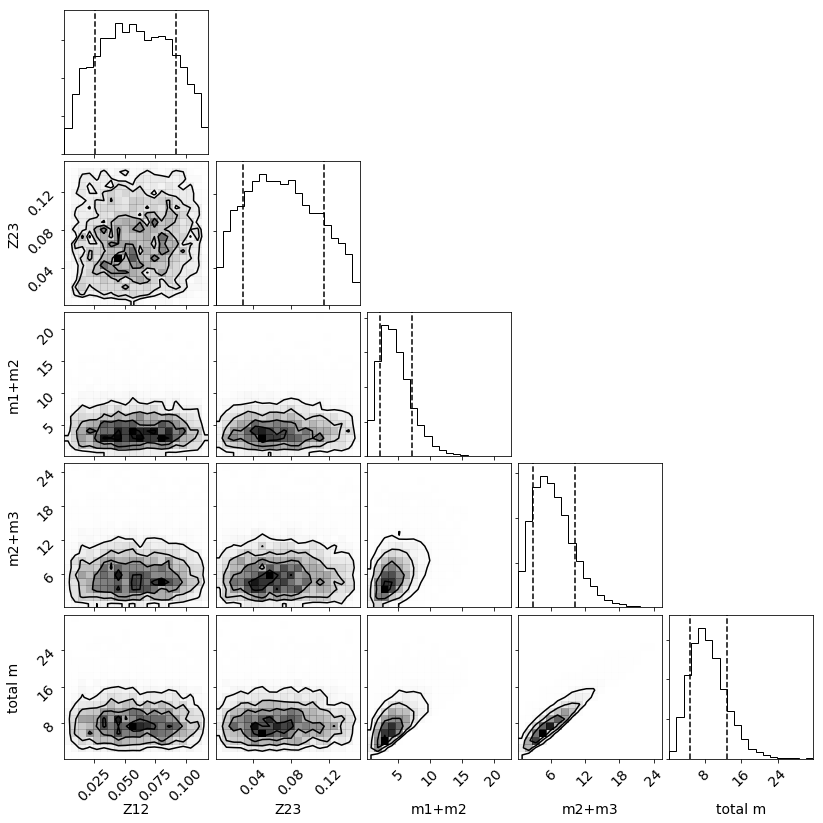

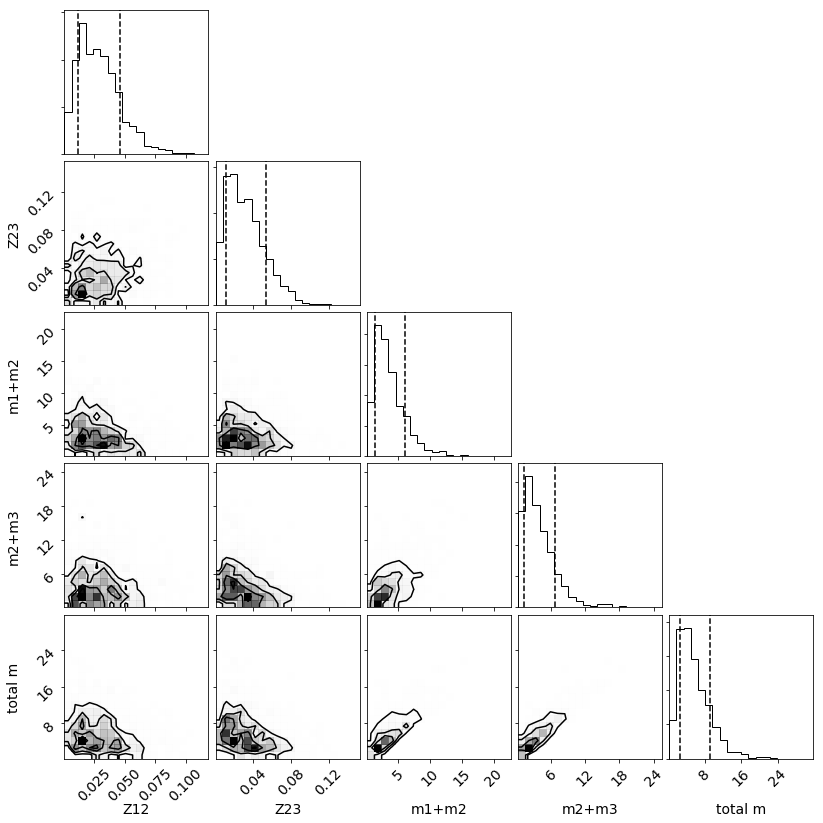

In [6]:
labels = ["Z12", "Z23", "m1+m2", "m2+m3", "total m"]
fig = corner.corner(df[labels], labels=labels, quantiles=[0.15,0.85], plot_datapoints=False)
plt.show()
fig = corner.corner(df[labels], labels=labels, quantiles=[0.15,0.85], plot_datapoints=False, weights=df["probstability"])
plt.show()

"sigma" before: 1.705068
"sigma" after: 1.507478
factor of 1.131073 smaller
"sigma" before: 1.700809
"sigma" after: 1.443630
factor of 1.178147 smaller
"sigma" before: 3.017133
"sigma" after: 1.854966
factor of 1.626516 smaller


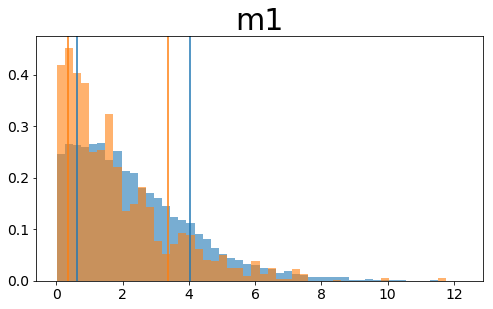

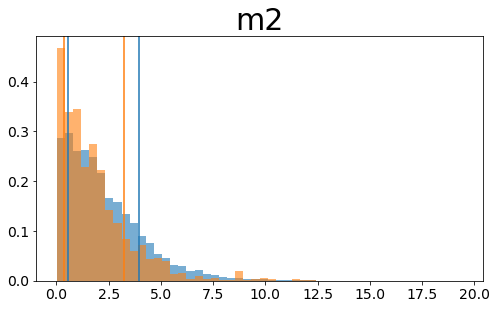

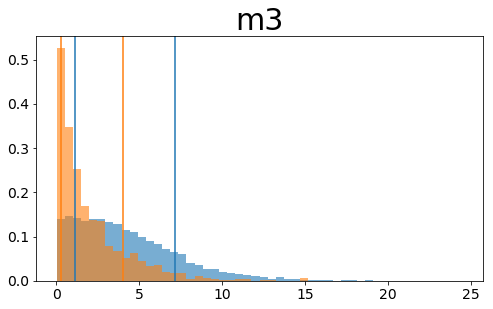

In [12]:
create_hist("m1")
create_hist("m2")
create_hist("m3")

"sigma" before: 2.457694
"sigma" after: 2.249403
factor of 1.092598 smaller
"sigma" before: 3.508580
"sigma" after: 2.506908
factor of 1.399564 smaller
"sigma" before: 3.954352
"sigma" after: 3.169491
factor of 1.247630 smaller


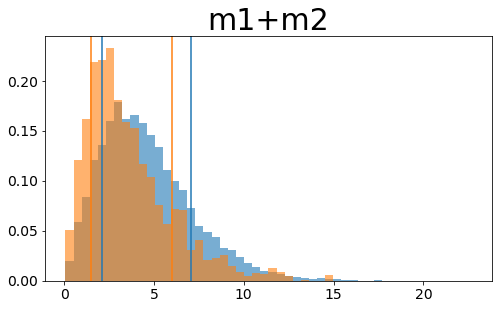

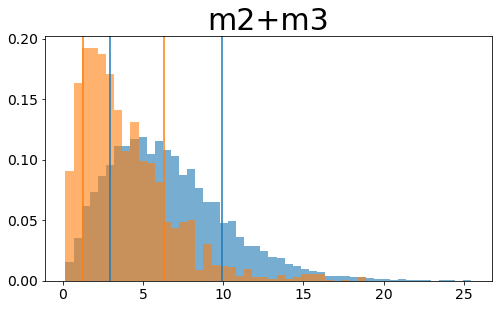

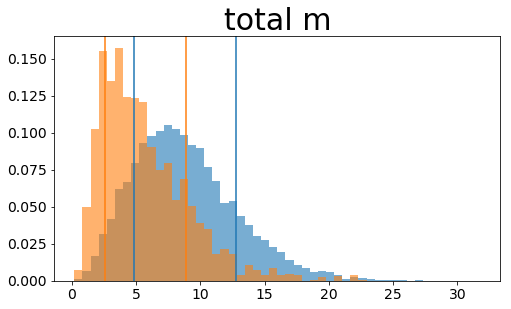

In [8]:
create_hist("m1+m2")
create_hist("m2+m3")
create_hist("total m")

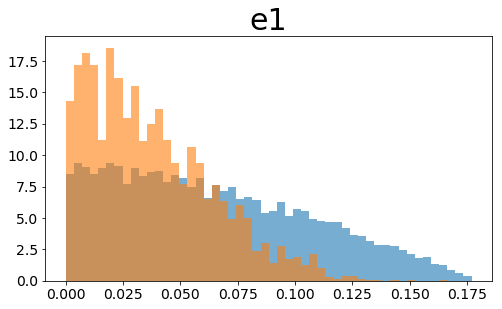

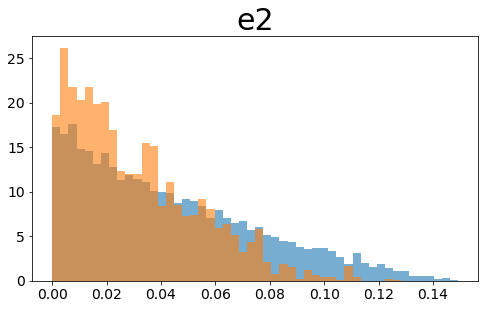

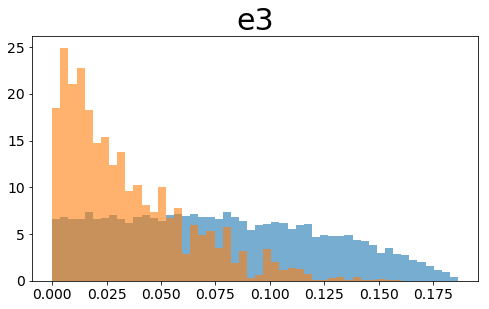

In [9]:
create_hist("e1", show_quantiles=False)
create_hist("e2", show_quantiles=False)
create_hist("e3", show_quantiles=False)

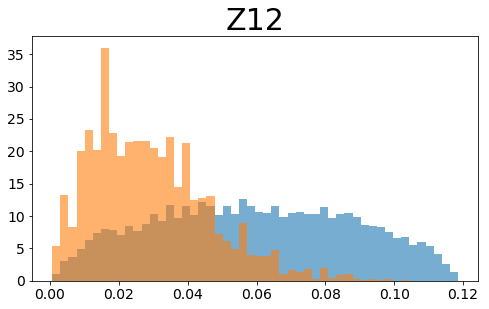

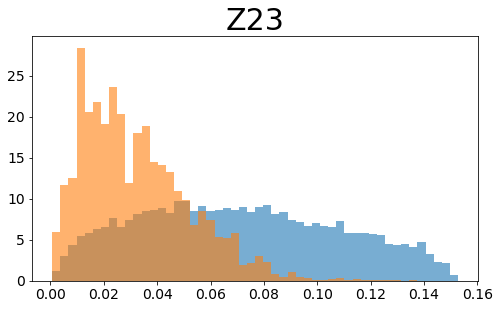

In [10]:
create_hist("Z12", show_quantiles=False)
create_hist("Z23", show_quantiles=False)